# Neurosynth >>> MNI icbm152 Asymmetric <<< Surface fsLR

## Preparations

### 1. Download the MNI atlases

> **ICBM 2009a Nonlinear Asymmetric template** - 1×1x1mm template which includes T1w,T2w,PDw modalities, and tissue probabilities maps. Intensity inhomogeneity was performed using N3 version 1.10.1. Also included brain mask, eye mask and face mask.

> **ICBM 2009c Nonlinear Asymmetric template** - 1×1x1mm template which includes T1w,T2w,PDw modalities, and tissue probabilities maps. Intensity inhomogeneity was performed using N3 version 1.11 Also included brain mask, eye mask and face mask.Sampling is different from 2009a template. 

### 2. Multiply the white matter probability mask by 20 and add it to the T1 to enhance the WM contrast to facilitate the segmentation of `fastsurfer`. Example below.

```bash
fslmaths mni_icbm152_wm_tal_nlin_asym_09a.nii -mul 20 -add mni_icbm152_t1_tal_nlin_asym_09a.nii mni_icbm152_asym_A.nii.gz
```

### 3. Run `fastsurfer` singularity container on the atlas.

```bash
# Number of threads
threads=15
# Image path
fastsurfer_img=fastsurfer-cpu-v2.2.0.sif
# Temporary directory path
export TMPDIR=/tmp/tmpfiles
# Freesurfer license
fs_license=/freesurfer-7.3.2/license.txt
# Path to outputs
SUBJECTS_DIR=/out/fastsurfer
# Subject ID
idBIDS=mni_icbm152_asym_C
# MRI|IMG to process
t1=mni_icbm152_asym_C.nii.gz

# Run the singularity container
singularity exec --writable-tmpfs --containall \
             -B "${SUBJECTS_DIR}":/output \
             -B "${TMPDIR}":/tmpdir \
             -B "${t1}":/tmpdir/${idBIDS}_T1w.nii.gz \
             -B "${fs_license}":/output/license.txt \
             "${fastsurfer_img}" \
                 /fastsurfer/run_fastsurfer.sh \
                 --fs_license /output/license.txt \
                 --t1 /tmpdir/${idBIDS}_T1w.nii.gz \
                 --sid "${idBIDS}" --sd /output --no_fs_T1 \
                 --parallel --threads "${threads}"
```

### 4. Download the `anatomical.nii.gz` from Neurosynth 

### 5. Registration via `freesurfer-7.4.1` `anatomical.nii.gz` to `mni_icbm152_asym_C.nii.gz`

```bash
# Segmentation of MNI atlas
atlas_mni152=mni_icbm152_nlin_asym/mni_icbm152_asym_C.nii.gz
atlas_mni152_seg=mni_icbm152_nlin_asym/mni_icbm152_asym_C_synthseg.nii.gz

mri_synthseg --i "${atlas_mni152}" \
             --o "${atlas_mni152_seg}" \
             --robust --threads "${threads}" --cpu --parc
               
# Segmentation of Neurosynth anatomical
neurosynth_anat=neurosynth/anatomical.nii.gz
neurosynth_anat_seg=neurosynth/anatomical_synthseg.nii.gz

mri_synthseg --i "${neurosynth_anat}" \
             --o "${neurosynth_anat_seg}" \
             --robust --threads "${threads}" --cpu --parc

# Registration from anatomical to MNI
mri_easyreg --ref "${atlas_mni152}" \
            --ref_seg "${atlas_mni152_seg}" \
            --flo "${neurosynth_anat}" \
            --flo_seg "${neurosynth_anat_seg}" \
            --fwd_field neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-easyreg_fwdfield.nii.gz \
            --bak_field neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-easyreg_bakfield.nii.gz \
            --threads ${threads}

# Apply registration to anatomical 
mri_easywarp --i "${neurosynth_anat}" \
             --o mni_icbm152_nlin_asym/anatomical_space-mni_icbm152_asym_C.nii.gz \
             --field neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-easyreg_fwdfield.nii.gz \
             --threads ${threads}
```

### 5. Registration via `ANTs` `anatomical.nii.gz` to `mni_icbm152_asym_C.nii.gz`

#### Image based registration
```bash
# [fixedImage,movingImage,initializationFeature]
threads=30
neurosynth_anat=neurosynth/anatomical.nii.gz
atlas_mni152=mni_icbm152_nlin_asym/mni_icbm152_asym_C_brain.nii.gz
centeralign="[${atlas_mni152},${neurosynth_anat},0]"
xfm_str=neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-SyN_
xfm_a=${xfm_str}0GenericAffine.mat
xfm_s=${xfm_str}1InverseWarp.nii.gz

# Register neurosynth to MNI152
antsRegistrationSyN.sh -d 3 -f "${atlas_mni152}" -m "${neurosynth_anat}" -o "${xfm_str}" -t s -n "${threads}" -p d -i "${centeralign}"

```

#### Label based registration
```bash
# [fixedImage,movingImage,initializationFeature]
threads=30
neurosynth_anat_seg=neurosynth/anatomical_synthseg.nii.gz
atlas_mni152_seg=mni_icbm152_nlin_asym/mni_icbm152_asym_C_synthseg.nii.gz
centeralign="[${atlas_mni152_seg},${neurosynth_anat_seg},0]"
xfm_str=neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-SyNlabels_
xfm_a=${xfm_str}0GenericAffine.mat
xfm_s=${xfm_str}1Warp.nii.gz

# Register neurosynth to MNI152
antsRegistrationSyN.sh -d 3 -f "${atlas_mni152_seg}" -m "${neurosynth_anat_seg}" -o "${xfm_str}" -t s -n "${threads}" -p d -i "${centeralign}"

# Apply  transformation T1nativepro to DWI-b0 space
neurosynth_anat=neurosynth/anatomical.nii.gz
atlas_mni152=mni_icbm152_nlin_asym/mni_icbm152_asym_C_brain.nii.gz

antsApplyTransforms -d 3 -i "${neurosynth_anat}" -r "${atlas_mni152}" \
    -t "$xfm_s" -t "$xfm_a" -o space-mniICBM152_asym_C_anatomical_SyNlab.nii.gz -v -u int
```

## Mapping `neurosynth` to MNI icbm152 Asymmetric surface

> The best registration seems to be **ANTs SyN image based**

### 1. Apply the segmentation to Neurosynth file
#### easyreg
```bash
threads=15
neurosynth_map=neurosynth/episodic_uniformity-test_z_FDR_0.01.nii.gz
mri_easywarp --i ${neurosynth_map} \
             --o mniICBM152_asym_C_${neurosynth_map} \
             --field neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-easyreg_fwdfield.nii.gz \
             --threads ${threads}
```

#### ANTs+synthseg
```bash
# Apply  transformation from Neurosynth anatomical to MNI152 asym
threads=15
neurosynth_map=neurosynth/episodic_uniformity-test_z_FDR_0.01.nii.gz

xfm_str=neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-SyNlabels_
xfm_a=${xfm_str}0GenericAffine.mat
xfm_s=${xfm_str}1Warp.nii.gz

antsApplyTransforms -d 3 -i "${neurosynth_map}" -r "${atlas_mni152}" \
    -t "$xfm_s" -t "$xfm_a" -o mni_icbm152_nlin_asym/space-mniICBM152_asym_C_episodic_uniformity.nii.gz -v -u int
```

## 2. Visualize for QC

In [123]:
from nilearn import plotting
import matplotlib as plt

# MNI space data
img_anat = '/host/yeatman/local_raid/rcruces/tmp/neurosynth/anatomical.nii.gz'
img_anat_mni = '/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym/mni_icbm152_asym_C_brain.nii.gz'

# Neurosynth
neuromap='association'
img_map = f'/host/yeatman/local_raid/rcruces/tmp/neurosynth/episodic_{neuromap}-test_z_FDR_0.01.nii.gz'
img_map_mni=f'/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym/space-mniICBM152_asym_C_episodic_{neuromap}.nii.gz'

def plot_map(img_anat, img_map, colorbar=False, display_mode='ortho', draw_cross=True,
             title='', black_bg=True, cut_coords=[-25, -18, 20],
             thr=4, a=1, cmap=plt.cm.YlOrRd, glass = False):
    
    # Plotting function
    if glass == True:
        func = plotting.plot_glass_brain
    else:
        func = plotting.plot_img
    
    # Add the anatomical image
    view_mri = func(img_anat, colorbar=colorbar, display_mode=display_mode, draw_cross=draw_cross,
                            title=title, cmap=plt.cm.Greys_r, black_bg=black_bg,
                            cut_coords=cut_coords)
    # Add the activation map
    view_mri.add_overlay(img_map, threshold=thr, alpha=a, cmap=cmap)
    
    return(view_mri)


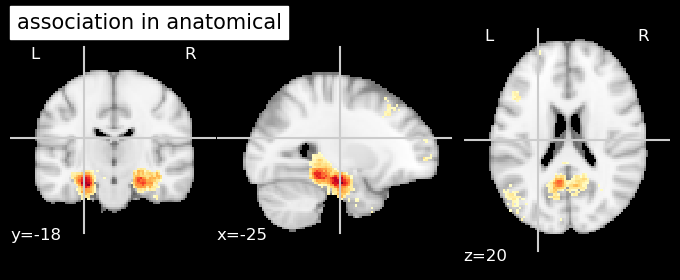

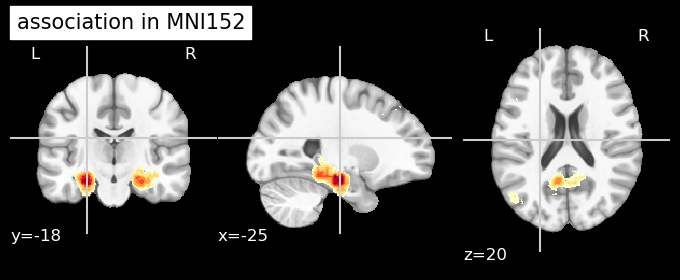

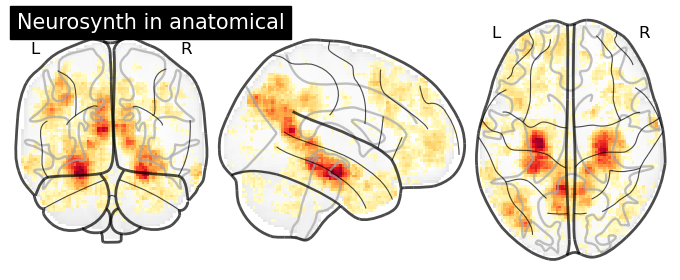

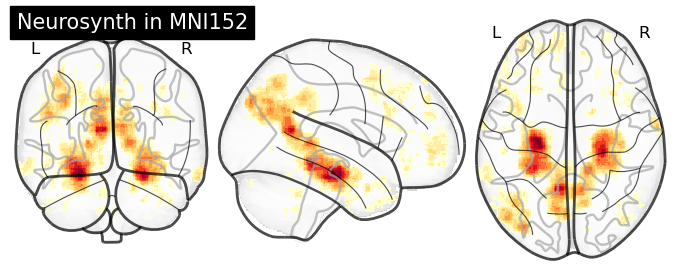

In [125]:
# Plot the Nifti and activation map from Neurosynth
plot_map(img_anat, img_map, title=f'{neuromap} in anatomical')
plot_map(img_anat_mni, img_map_mni, title=f'{neuromap} in MNI152')

# Plot the Nifti and activation map from Neurosynth
plot_map(img_anat, img_map, title='Neurosynth in anatomical', glass=True, thr=3, black_bg=False)
plot_map(img_anat_mni, img_map_mni, title='Neurosynth in MNI152', glass=True, thr=3, black_bg=False)

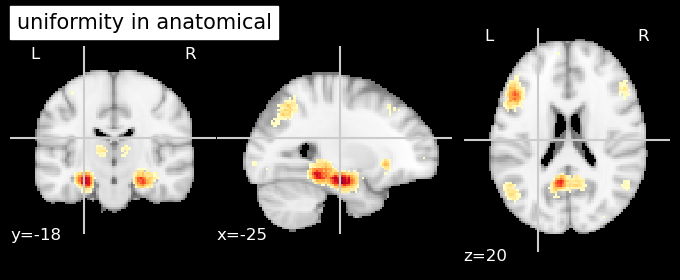

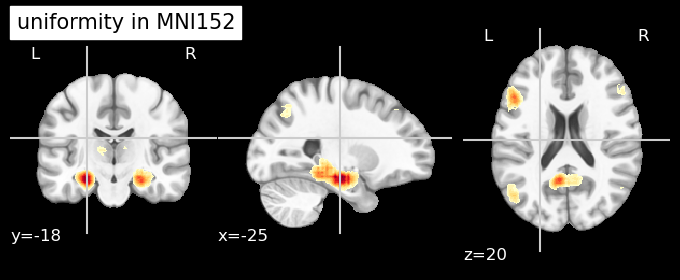

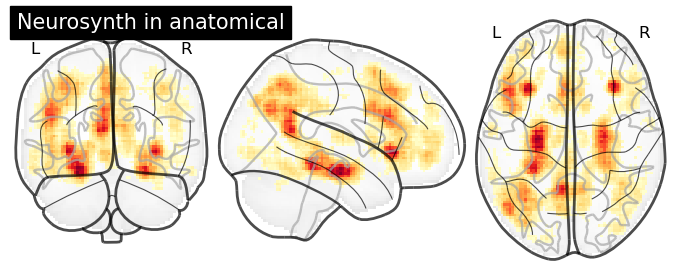

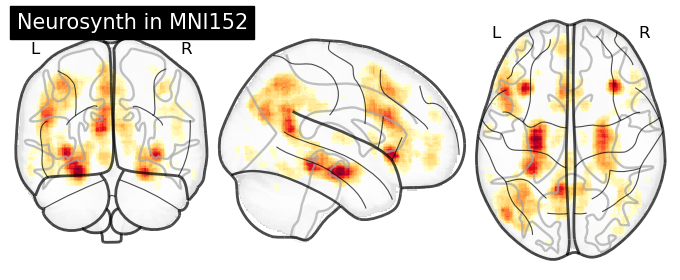

In [128]:
neuromap='uniformity'
img_map = f'/host/yeatman/local_raid/rcruces/tmp/neurosynth/episodic_{neuromap}-test_z_FDR_0.01.nii.gz'
img_map_mni=f'/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym/space-mniICBM152_asym_C_episodic_{neuromap}.nii.gz'

# Plot the Nifti and activation map from Neurosynth
plot_map(img_anat, img_map, title=f'{neuromap} in anatomical')
plot_map(img_anat_mni, img_map_mni, title=f'{neuromap} in MNI152')

# Plot the Nifti and activation map from Neurosynth
plot_map(img_anat, img_map, title='Neurosynth in anatomical', glass=True, thr=3, black_bg=False)
plot_map(img_anat_mni, img_map_mni, title='Neurosynth in MNI152', glass=True, thr=3, black_bg=False)


### 2. Generation of  MNI ICBM 152 to Surfaces
```bash
# Generate the midthickness surface
cd fastsurfer/mni_icbm152_asym_C/surf
HEMI=R
dir_surf='/data_/mica1/01_programs/micapipe-v0.2.0/surfaces'
dir_out='/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym/'

wb_shortcuts -freesurfer-resample-prep \
    rh.white rh.pial rh.sphere.reg \
    ${dir_surf}/fsLR-32k.${hemi}.sphere.reg.surf.gii \
    ${dir_out}/mni_icbm152_asym_C_hemi-${HEMI}_surf-fsnative_label-midthickness.surf.gii \
    ${dir_out}/mni_icbm152_asym_C_hemi-${HEMI}_surf-fsLR-32k_label-midthickness.surf.gii \
    ${dir_out}/mni_icbm152_asym_C_hemi-${HEMI}_surf-fsnative_label-sphere.surf.gii

# Convert from Freesurface format to GIFTI
dir_surf='/host/yeatman/local_raid/rcruces/tmp/fastsurfer/mni_icbm152_asym_C/surf'
subject='mni_icbm152_asym_C'
mris_convert ${dir_surf}/lh.white ${subject}_hemi-L_surf-fsnative_label-white.surf.gii
mris_convert ${dir_surf}/rh.white ${subject}_hemi-R_surf-fsnative_label-white.surf.gii
mris_convert ${dir_surf}/rh.pial ${subject}_hemi-R_surf-fsnative_label-pial.surf.gii
mris_convert ${dir_surf}/lh.pial ${subject}_hemi-L_surf-fsnative_label-pial.surf.gii

```
# From Neurosynth to MNI ICBM 152 to Surface

## Apply registrations to neurosynth map to ICBM 152 space
```bash
# Apply  transformation from Neurosynth anatomical to MNI152 asym
threads=15
neurosynth_map=neurosynth/episodic_uniformity-test_z_FDR_0.01.nii.gz

xfm_str=neurosynth/from-neurosynth_to-mniICBM152_asym_C_desc-SyNlabels_
xfm_a=${xfm_str}0GenericAffine.mat
xfm_s=${xfm_str}1Warp.nii.gz

antsApplyTransforms -d 3 -i "${neurosynth_map}" -r "${atlas_mni152}" \
    -t "$xfm_s" -t "$xfm_a" -o mni_icbm152_nlin_asym/space-mniICBM152_asym_C_episodic_uniformity.nii.gz -v -u int
```

## Map from volume to surface

```bash
# Change directory into the mni working dir
cd /host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym

# Map from MNI ICBM 152 to Surface
neuromap="uniformity"
# neuromap="association"
img_map_mni="/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym/space-mniICBM152_asym_C_episodic_${neuromap}.nii.gz"
subject="mni_icbm152_asym_C"
label="midthickness"

# Cortical surface
for HEMI in L R; do
    surf_mt="${subject}_hemi-${HEMI}_surf-fsnative_label-${label}.surf.gii"

    map_on_surf="${subject}_hemi-${HEMI}_surf-fsnative_label-${label}_episodic_${neuromap}.func.gii"
    cmd="wb_command -volume-to-surface-mapping ${img_map_mni} ${surf_mt} ${map_on_surf} -trilinear"
    $cmd; echo $cmd
done

# Hippocampal surface
for HEMI in L R; do
    surf_hip="tpl-MNI152NLin2009cAsym_hemi-${HEMI}_space-T1w_den-1mm_label-hipp_midthickness.surf.gii"
    
    map_on_surf="${subject}_hemi-${HEMI}_surf-fsnative_label-hipp_midthickness_episodic_${neuromap}.func.gii"
    cmd="wb_command -volume-to-surface-mapping ${img_map_mni} ${surf_hip} ${map_on_surf} -trilinear"
done
```
## Resample to fsLR-32k

In [165]:
%%bash
# Change working directory
cd "/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym/"

# Variables
subject="mni_icbm152_asym_C"
label="midthickness"
Surf="fsLR-32k"
util_surface="/data_/mica1/01_programs/micapipe-v0.2.0/surfaces/"

# For each neuromap and each hemisphere: Resample to fsLR-32k
for HEMI in L R; do for neuromap in association uniformity; do
map_on_surf="${subject}_hemi-${HEMI}_surf-fsnative_label-${label}_episodic_${neuromap}.func.gii"

wb_command -metric-resample "${map_on_surf}" \
        "${subject}_hemi-${HEMI}_surf-fsnative_label-sphere.surf.gii" \
        "${util_surface}/${Surf}.${HEMI}.sphere.reg.surf.gii" \
        BARYCENTRIC "${subject}_hemi-${HEMI}_surf-${Surf}_label-${label}_episodic_${neuromap}.func.gii"
done; done

## Plot neurosynth from MNI icbm 152 asym to surface

In [149]:
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
import numpy as np
import nibabel as nb
import cmocean
cmaps = cmocean.cm.cmap_d

# MNI directory
mni_dir = '/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym'

# Load native mid surface
subject="mni_icbm152_asym_C"
label='midthickness'
surf_lh = read_surface(f'{mni_dir}/{subject}_hemi-L_surf-fsnative_label-{label}.surf.gii', itype='gii')
surf_rh = read_surface(f'{mni_dir}/{subject}_hemi-R_surf-fsnative_label-{label}.surf.gii', itype='gii')

# Load the neurosynth map
neuromap='association'
file_lh = f'{mni_dir}/{subject}_hemi-L_surf-fsnative_label-midthickness_episodic_{neuromap}.func.gii'
file_rh = f'{mni_dir}/{subject}_hemi-R_surf-fsnative_label-midthickness_episodic_{neuromap}.func.gii'
surf_map = np.hstack(np.concatenate((nb.load(file_lh).darrays[0].data, 
                                     nb.load(file_rh).darrays[0].data), axis=0))
surf_map.shape

(307817,)

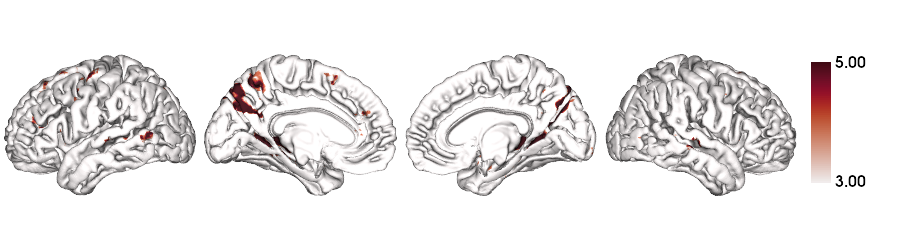

In [150]:
# Plot on surface
plot_hemispheres(surf_lh, surf_rh, array_name=surf_map, cmap='cmo.amp', nan_color=(0, 0, 0, 1), 
                 transparent_bg=True, zoom=1.25, size=(900, 250), embed_nb=True, color_bar='right', 
                 color_range=(3,5), share='both', screenshot=False)


In [151]:
# Load the neurosynth map
neuromap='uniformity'
file_lh = f'{mni_dir}/{subject}_hemi-L_surf-fsnative_label-midthickness_episodic_{neuromap}.func.gii'
file_rh = f'{mni_dir}/{subject}_hemi-R_surf-fsnative_label-midthickness_episodic_{neuromap}.func.gii'
surf_map = np.hstack(np.concatenate((nb.load(file_lh).darrays[0].data, 
                                     nb.load(file_rh).darrays[0].data), axis=0))


surf_map.shape

(307817,)

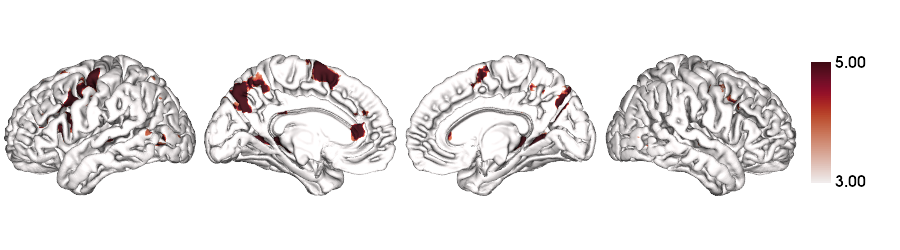

In [152]:
# Plot on surface
plot_hemispheres(surf_lh, surf_rh, array_name=surf_map, cmap='cmo.amp', nan_color=(0, 0, 0, 1), 
                 transparent_bg=True, zoom=1.25, size=(900, 250), embed_nb=True, color_bar='right', 
                 color_range=(3,5), share='both', screenshot=False)

# Plot on fsLR-32k inflated surface

In [170]:
# MNI directory
mni_dir = '/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym'

# Load fsLR-32k inflated surface
util_surface="/data_/mica1/01_programs/micapipe-v0.2.0/surfaces/"
subject="mni_icbm152_asym_C"

inf_lh = read_surface(f'{util_surface}/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(f'{util_surface}/fsLR-32k.R.inflated.surf.gii', itype='gii')

# Load the neurosynth map
neuromap='association'
fsLR_lh = f'{mni_dir}/{subject}_hemi-L_surf-fsLR-32k_label-midthickness_episodic_{neuromap}.func.gii'
fsLR_rh = f'{mni_dir}/{subject}_hemi-R_surf-fsLR-32k_label-midthickness_episodic_{neuromap}.func.gii'
fsLR_map = np.hstack(np.concatenate((nb.load(fsLR_lh).darrays[0].data, 
                                     nb.load(fsLR_rh).darrays[0].data), axis=0))

neuromap='uniformity'
fsLR_lh = f'{mni_dir}/{subject}_hemi-L_surf-fsLR-32k_label-midthickness_episodic_{neuromap}.func.gii'
fsLR_rh = f'{mni_dir}/{subject}_hemi-R_surf-fsLR-32k_label-midthickness_episodic_{neuromap}.func.gii'
fsLR_uni = np.hstack(np.concatenate((nb.load(fsLR_lh).darrays[0].data, 
                                     nb.load(fsLR_rh).darrays[0].data), axis=0))


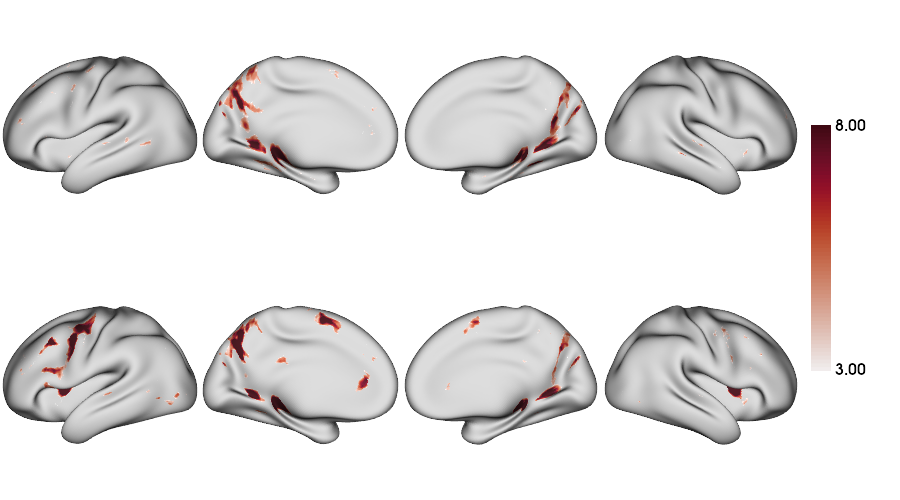

In [185]:
# Plot on surface
fsLR_map[fsLR_map < 3] = np.nan
fsLR_uni[fsLR_uni < 3] = np.nan

gray_per=0.75
plot_hemispheres(inf_lh, inf_rh, array_name=[fsLR_map, fsLR_uni], cmap='cmo.amp', nan_color=(gray_per, gray_per, gray_per, 1), 
                 transparent_bg=True, zoom=1.25, size=(900, 500), embed_nb=True, color_bar='right', 
                 color_range=(3,8), share='both', screenshot=False)

# Hippocampus

In [155]:
# MNI directory
mni_dir = '/host/yeatman/local_raid/rcruces/tmp/mni_icbm152_nlin_asym'
subject="mni_icbm152_asym_C"
label='hipp_midthickness'
neuromap='uniformity'

# Load native mid surface
lh_hip = read_surface(f'{mni_dir}/tpl-MNI152NLin2009cAsym_hemi-L_space-T1w_den-1mm_label-{label}.surf.gii', itype='gii')
rh_hip = read_surface(f'{mni_dir}/tpl-MNI152NLin2009cAsym_hemi-R_space-T1w_den-1mm_label-{label}.surf.gii', itype='gii')

# Load the neurosynth map
file_lh = f'{mni_dir}/mni_icbm152_asym_C_hemi-L_surf-fsnative_label-{label}_episodic_{neuromap}.func.gii'
file_rh = f'{mni_dir}/mni_icbm152_asym_C_hemi-R_surf-fsnative_label-{label}_episodic_{neuromap}.func.gii'
surf_hip = np.hstack(np.concatenate((nb.load(file_lh).darrays[0].data, 
                                     nb.load(file_rh).darrays[0].data), axis=0))


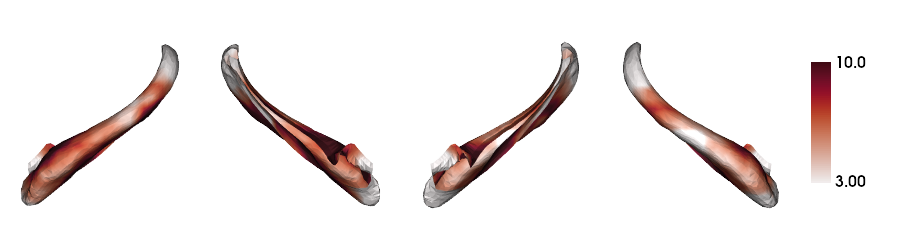

In [156]:
# Plot on surface
plot_hemispheres(lh_hip, rh_hip, array_name=surf_hip, cmap='cmo.amp', nan_color=(0, 0, 0, 1), 
                 transparent_bg=True, zoom=1.25, size=(900, 250), embed_nb=True, color_bar='right', 
                 color_range=(3,10), share='both', screenshot=False)


## Optional create a DICE score coefficient to assess segmentation accuracy